In [14]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils 


OBSERVER_TYPE = "gaussian"
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_TYPE = "connection"
OBS_OUT_DIM = 20
OBS_SIGMA = 1.75
NUM_STIM_CHANNELS = 16
STIM_SIGMA = 2.175
BATCH_SIZE = 128
KFOLDS = 5
CUDA = True

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              obs_out_dim=OBS_OUT_DIM,
                                              obs_sigma=OBS_SIGMA,
                                              cuda=CUDA)


CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)

if CUDA:
    mike.cuda()

mike.set_lesion(lesion_instance)


In [16]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA)

probs = torch.ones(len(dataset)) / float(len(dataset))
holdout_count = int(len(dataset) / KFOLDS)
holdout_idxs = set([p.item() for p in probs.multinomial(num_samples=holdout_count)])

train = []
test = []
for idx in range(len(dataset)):
    if idx in holdout_idxs:
        test.append(dataset[idx])
    else:
        train.append(dataset[idx])

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_train = DataLoader(
  train, batch_size=len(train), shuffle=True,
)
loader_test = DataLoader(
  test, batch_size=len(test), shuffle=True,
)

torch.Size([341, 21])
torch.Size([1, 341, 50])
torch.Size([1, 341, 50])


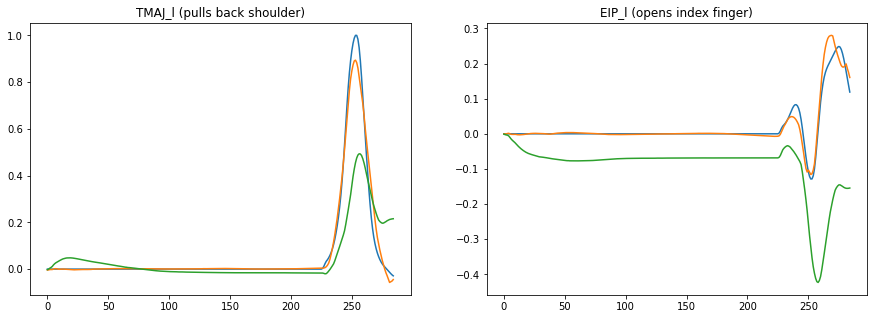

In [19]:
# Just some choice of examples, for graphical comparison
example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


print(example_din.shape)
print(reference_pred_healthy.shape)
print(reference_pred_lesioned.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(example_dout[:trial_len, 7].cpu().detach().numpy())
ax[0].plot(reference_pred_healthy[0, :trial_len, 7].cpu().detach().numpy())
ax[0].plot(reference_pred_lesioned[0, :trial_len, 7].cpu().detach().numpy())
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(example_dout[:trial_len, 45].cpu().detach().numpy())
ax[1].plot(reference_pred_healthy[0, :trial_len, 45].cpu().detach().numpy())
ax[1].plot(reference_pred_lesioned[0, :trial_len, 45].cpu().detach().numpy())

plt.show()

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>)


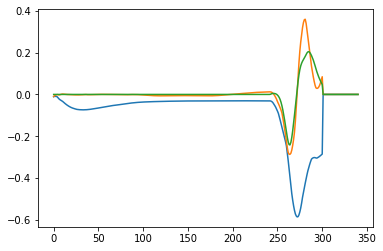

In [20]:
# Now a numerical comparison
comp_loss = torch.nn.MSELoss()

loader_comp = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)
for s in loader_comp:
    din, trial_end, _, dout = s

comp_preds_healthy = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_healthy = comp_preds_healthy.cuda()
    
mike.set_lesion(None)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_healthy[:, tidx, :] = p[:, :]
comp_preds_healthy = utils.trunc_to_trial_end(comp_preds_healthy, trial_end)
comp_loss_healthy = comp_loss(comp_preds_healthy, dout)
print(comp_loss_healthy)

comp_preds_lesioned = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_lesioned = comp_preds_lesioned.cuda()
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_lesioned[:, tidx, :] = p[:, :]
comp_preds_lesioned = utils.trunc_to_trial_end(comp_preds_lesioned, trial_end)
comp_loss_lesioned = comp_loss(comp_preds_lesioned, dout)
print(comp_loss_lesioned)


plt.plot(comp_preds_lesioned[0, :, 20].cpu().detach().numpy())
plt.plot(comp_preds_healthy[0, :, 20].cpu().detach().numpy())
plt.plot(dout[0, :, 20].cpu().detach().numpy())
plt.show()


In [22]:
def unroll(cpn, mike, en, din, trial_end, observer,
           drop_module_idx=None, retain_stim_grads=False,
           cuda=False):
    batch_size = din.shape[0]
    steps = din.shape[1]
    obs_dim = 3 * observer.out_dim

    stims = []
    preds = torch.zeros(batch_size, steps - 1, en.out_dim)
    actuals = torch.zeros(batch_size, steps - 1, en.out_dim)

    if cuda:
        preds = preds.cuda()
        actuals = actuals.cuda()

    # This is the actual, which EN predicts
    mike_out = mike(din[:, 0, :].T)

    for tidx in range(steps - 1):
        obs = mike.observe(observer, drop_module_idx=drop_module_idx)
        new_obs_cpn = torch.cat(obs, axis=1).detach()
        new_obs_en = obs[0].detach()

        # cpn recieves (obs, trial_end)
        cpn_in = torch.cat((new_obs_cpn, trial_end[:, tidx, :]), axis=1)
        # output is (batch_size, num_stim_channels)
        new_stim = cpn(cpn_in)
        assert new_stim.shape == (batch_size, mike.stimulus.num_stim_channels)
        if retain_stim_grads:
            new_stim.retain_grad()
        stims.append(new_stim)

        # en receives (obs, stims, trial_end)
        en_in = torch.cat((new_obs_en, new_stim, trial_end[:, tidx, :]), axis=1)
        cur_pred = en(en_in)
        preds[:, tidx, :] = cur_pred[:, :]

        # new_stim will be cloned in here, to prevent accidentally backprop-ing
        # through the "brain", aka mike.
        mike.stimulate(new_stim)

        # Note that 'preds' lags 'actual' by a time step, hence
        # 'pred' is a prediction of the actual en activity
        mike_out = mike(din[:, tidx + 1, :].T)
        actuals[:, tidx, :] = mike_out[:, :]

    actuals = utils.trunc_to_trial_end(actuals, trial_end[:, :-1, :])
    preds = utils.trunc_to_trial_end(preds, trial_end[:, :-1, :])
    return actuals, preds, stims

In [23]:
def train_an_en(mike, observer, cpn, data_loader, en=None,
                last_loss=1, drop_module_idx=None, cuda=False):
    # the last EN we were working on training, for easy access
    global recent_en

    obs_dim = observer.out_dim * 1
    # Stim: mike.stimulus.num_stim_channels
    # +1 for trial_end
    en_in_dim = obs_dim + mike.stimulus.num_stim_channels + 1
    if en is None:
        en = stim_model.StimModel(en_in_dim, mike.output_dim,
                num_neurons=en_in_dim+50, activation_func=torch.nn.Tanh,
                cuda=cuda)

        if cuda:
            en.cuda()

        recent_en = en
    vl = torch.tensor(1.0)
    opt_en = AdamW(en.parameters(), lr=9e-3, weight_decay=0.04)

    checkpoint_eidx = 0
    eidx = -1
    while True:
        for batch in data_loader:
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
            eidx += 1
            opt_en.zero_grad()
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()

            for p in opt_en.param_groups:
                #if eidx < 3:
                #    p['lr'] = 2e-2
                if vl.item() < 0.0007:
                    p['lr'] = 1e-4
                elif vl.item() < 0.005:
                    p['lr'] = 3e-3
                else:
                    p['lr'] = 4e-3

            cpn_noise = cpn_model.CPNNoiseyLSTMCollection(cpn, noise_var=(last_loss), white_noise_pct=0.4,
                                                          white_noise_var=6,
                                                          cuda=cuda)

            # Just in case...
            for param in mike.parameters():
                param.requires_grad=False

            actual, preds, _ = unroll(cpn_noise, mike, en, din, trial_end,
                                      observer, drop_module_idx=drop_module_idx,
                                      cuda=cuda)

            # Update en
            rl = loss(preds, actual)
            rl.backward()
            opt_en.step()

            # Verify against the actual CPN
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()
            actual_val, preds_val, _ = unroll(cpn, mike, en, din,
                                              trial_end, observer,
                                              drop_module_idx=drop_module_idx,
                                              cuda=cuda)

            vl = loss(preds_val, actual_val)
            print("en", eidx, rl.item(), "val:", vl.item())

            if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
                # Emergency eject button
                en = stim_model.StimModel(en.in_dim, en.out_dim, num_neurons=en.num_neurons,
                                       activation_func=en.activation_func_t)

                if cuda:
                    en.cuda()

                recent_en = en
                opt_en = AdamW(en.parameters(), lr=1e-3, weight_decay=0.04)
                checkpoint_eidx = eidx

            if (vl.item() < max(0.02 * last_loss, 5e-4) and eidx > 100) or (eidx - checkpoint_eidx) == 2000:
                done = True
                break
            else:
                done = False

        if done:
            break

    opt_en.zero_grad()
    return en

In [24]:
obs_dim = observer.out_dim * 3
# +1 for trial_end
cpn_in_dim = obs_dim + 1
#cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
#                             num_neurons=cpn_in_dim, activation_func=torch.nn.Tanh,
#                             cuda=CUDA)

if CUDA:
    cpn._cuda = cuda
    cpn.cuda()

#cpn.load_state_dict(torch.load('latest_cpn_F5condrop_obs20_stim16_cuda'))

opt_cpn = AdamW(cpn.parameters(), lr=5e-6)

loss = torch.nn.MSELoss()
rli = 0.005

cpn_losses = []
pred_losses = []
real_losses = []
test_losses = []
super_epoch_count = 0
en = None
eidx = -1
while True:
    super_epoch_count += 1

    for param in cpn.parameters():
        param.requires_grad=False

    #if super_epoch_count > 1:
    en = train_an_en(mike, observer, cpn, loader_train, last_loss=rli, cuda=CUDA)

    for param in cpn.parameters():
        param.requires_grad=True
    for param in en.parameters():
        param.requires_grad=False
    for param in mike.parameters():
        param.requires_grad=False

    recent_losses = []
    num_regressed = 0
    while True:
        for batch in loader_train:
            eidx += 1
            opt_cpn.zero_grad()
            cpn.reset()
            en.reset()
            mike.reset()

            if rli >= 0.01:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-3
            else:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-4

            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]

            actuals, preds, stims = unroll(cpn, mike, en, din, trial_end, observer,
                                           retain_stim_grads=True,
                                           cuda=CUDA)
            preds.retain_grad()

            rl = loss(preds, dout[:, 1:, :])
            rli = rl.item()
            rl.backward()

            cpn_losses.append(rli)

            real_loss = torch.nn.MSELoss()(actuals, dout[:, 1:, :]).item()
            real_losses.append(real_loss)

            pred_loss = torch.nn.MSELoss()(preds, actuals).item()
            pred_losses.append(pred_loss)

            print("cpn", eidx, rl.item(),
                  "en loss:", pred_loss,
                  "actual task loss:", real_loss)
            recent_losses.append(real_loss)

            torch.save(cpn.state_dict(), "latest_cpn_F5condrop_obs20_stim16_cuda")
            torch.save(en.state_dict(), "latest_en")
            if real_loss == min(recent_losses) and real_loss < 0.0075:
                torch.save(cpn.state_dict(), "min_cpn_F5condrop_obs20_stim16_cuda")

            bail = False
            done = False
            # Done
            if rli < 1e-5:
                bail = True
                done = True
                break

            if pred_loss > max(real_loss / 10, 6e-4):
                bail = True
                break

            if len(recent_losses) >= 500:
                bail = True
                break

            if len(recent_losses) > 30:
                prev = None
                num_reg = 0
                for l in recent_losses[-30:]:
                    if prev is not None and l > prev:
                        num_reg += 1

                prev = l
                if num_reg > 15:
                    bail = True
                    break

            opt_cpn.step()

            if bail:
                break

        if bail:
            break

        # Test
        cpn.reset()
        en.reset()
        mike.reset()

        batch_test = next(iter(loader_test))
        din_test, trial_end_test, trial_len_test, dout_test = batch_test
        batch_size_test = din_test.shape[0]
        steps_test = din_test.shape[1]
        actuals_test, preds_test, stims_test = unroll(cpn, mike, en, din_test,
                                           trial_end_test, observer, cuda=CUDA)

        rl = loss(actuals_test, dout_test[:, 1:, :])
        rli = rl.item()
        print("cpn", eidx, f"test loss: {rli}")
        test_losses.append(rli)

    if done:
        break
        
# Best with trial ends 0.0048

AttributeError: 'CPNModelLSTM' object has no attribute '_cuda'

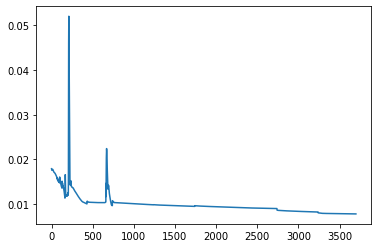

0.007344400975853205


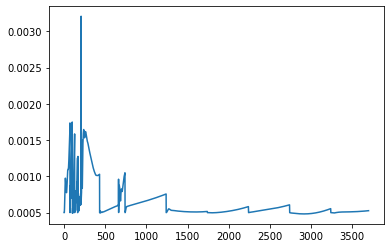

0.00048186880303546786


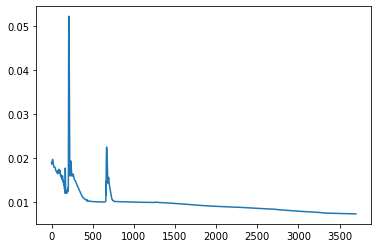

0.006985321640968323


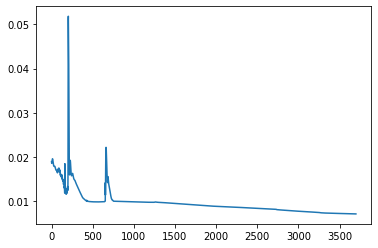

0.006863930728286505
0.6815758050799908 tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0006, grad_fn=<MseLossBackward>)


In [9]:
plt.plot(cpn_losses)
plt.show()
print(min(cpn_losses))

plt.plot(pred_losses)
plt.show()
print(min(pred_losses))

plt.plot(real_losses)
plt.show()
print(min(real_losses))

plt.plot(test_losses)
plt.show()
print(min(test_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

In [26]:
# TODO: get a CPN collection and explore the impact of the level of noise we are using.
# TODO: look for classes or data points we suck at
# TODO: train vs test
# TODO: deep dive EN grads bad

print(recent_losses)

[0.012536630965769291, 0.012541639618575573]


torch.Size([1, 341, 50])


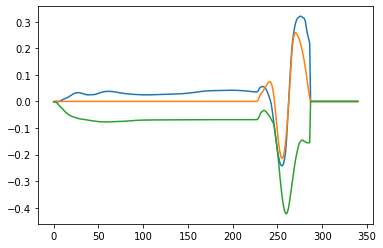

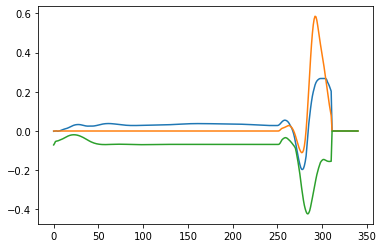

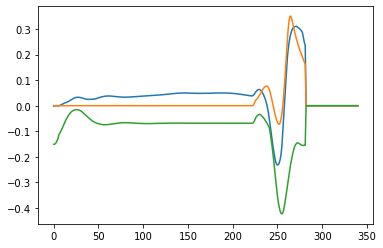

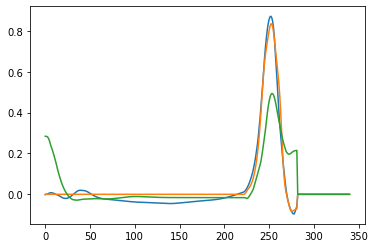

In [17]:
mike.reset()
reference_pred_lesioned_0 = mike.unroll(din[0, :, :].T)
reference_pred_lesioned_neg1 = mike.unroll(din[-1, :, :].T)
reference_pred_lesioned_20 = mike.unroll(din[20, :, :].T)
mike.reset()

reference_pred_lesioned_0 = utils.trunc_to_trial_end(reference_pred_lesioned_0, trial_end[0, :])
reference_pred_lesioned_neg1 = utils.trunc_to_trial_end(reference_pred_lesioned_neg1, trial_end[-1, :])
reference_pred_lesioned_20 = utils.trunc_to_trial_end(reference_pred_lesioned_20, trial_end[20, :])


print(reference_pred_lesioned_0.shape)


#plt.plot(preds[0, :, 45].detach().numpy())
#plt.plot(preds.grad[0, :, 45].detach().numpy())
plt.plot(actuals[0, :, 45].detach().numpy())
plt.plot(dout[0, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_0[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[-1, :, 45].detach().numpy())
plt.plot(actuals[-1, :, 45].detach().numpy())
plt.plot(dout[-1, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_neg1[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 45].detach().numpy())
plt.plot(actuals[20, :, 45].detach().numpy())
plt.plot(dout[20, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 7].detach().numpy())
plt.plot(actuals[20, :, 7].detach().numpy())
plt.plot(dout[20, :, 7].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 7].detach().numpy())
plt.show()

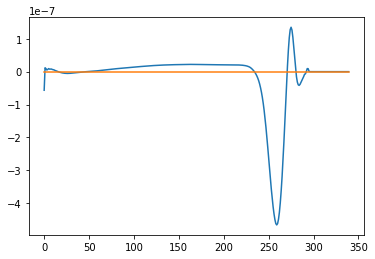

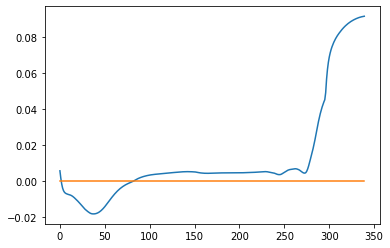

IndexError: index 20 is out of bounds for dimension 1 with size 16

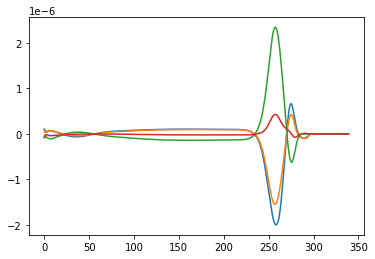

In [16]:
ss = [x[20, 6].item() for x in stims]
gg = [x.grad[20, 6].item() for x in stims]
ref = [0.0 for x in stims]

plt.plot(gg)
plt.plot(ref)
plt.show()
plt.plot(ss)
plt.plot(ref)
plt.show()

for idx in range(0, 25, 5):
    gg = [x.grad[20, idx].item() for x in stims]
    plt.plot(gg)
plt.show()

# On bad run: gradient is negative when values are too high

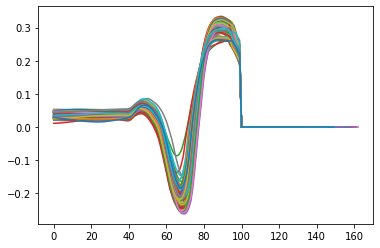

In [52]:
# Are gestures taken between classes?
stout = []
bsize = actuals.shape[0]

for bidx in range(bsize):
    stout.append(actuals[bidx, (trial_len[bidx].item()-100):, 45].detach().numpy())

for i in range(bidx):
    plt.plot(stout[i])
    
plt.show()

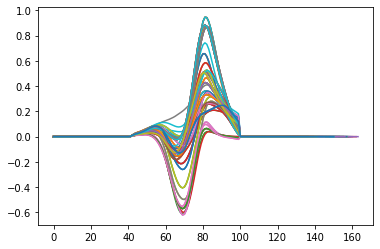

In [53]:
# How does that compare to targets?
stout = []
bsize = dout.shape[0]
for bidx in range(bsize):
    stout.append(dout[bidx, (trial_len[bidx].item()-100):, 45].detach().numpy())

for i in range(bidx):
    plt.plot(stout[i])
    
plt.show()